5


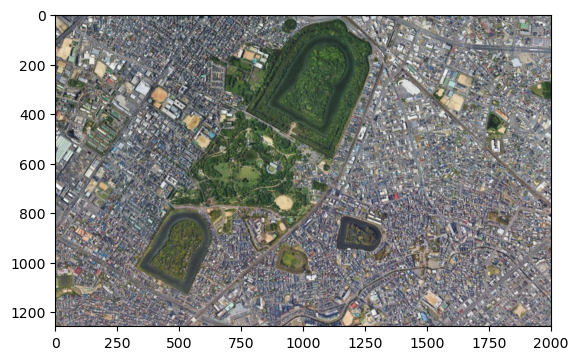

In [ ]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os 
from glob import glob
# Get the test images 
files = sorted(glob("SAT*.png")) #Get png files 
print(len(files))

img=cv2.imread(files[0])
plt.imshow(img[:,:,[2,1,0]])

# Canny 

Text(0.5, 1.0, 'Grayscale Histogram')

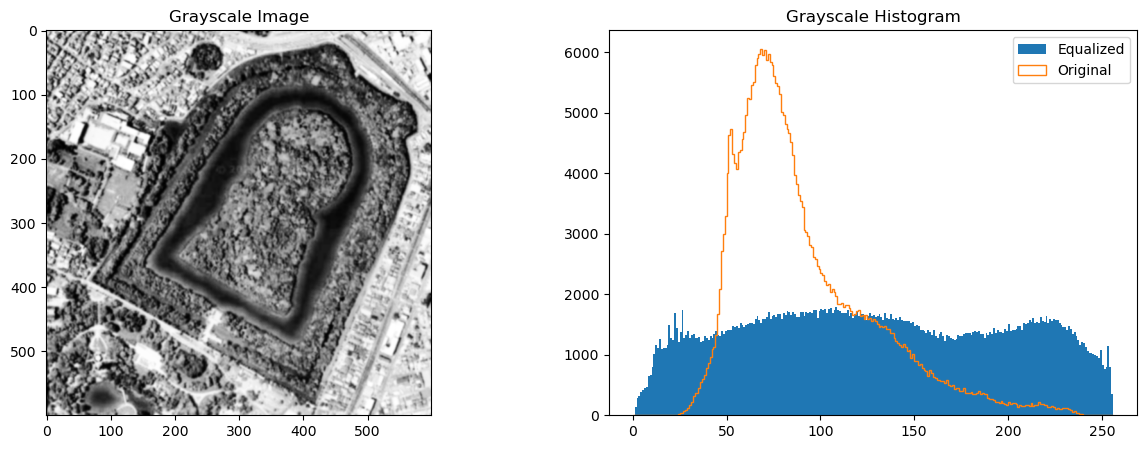

In [253]:

use_image= img[0:600,700:1300]
gray = cv2.cvtColor(use_image, cv2.COLOR_BGR2GRAY)
gray_og = gray.copy()
gray = cv2.equalizeHist(gray)
gray = cv2.GaussianBlur(gray, (9, 9),1)

plt.figure(figsize=(15, 5))
plt.subplot(121), plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.subplot(122)
_= plt.hist(gray.ravel(), 256, [0,256],label="Equalized") 
_ = plt.hist(gray_og.ravel(), 256, [0,256],label="Original",histtype='step')
plt.legend()
plt.title('Grayscale Histogram')

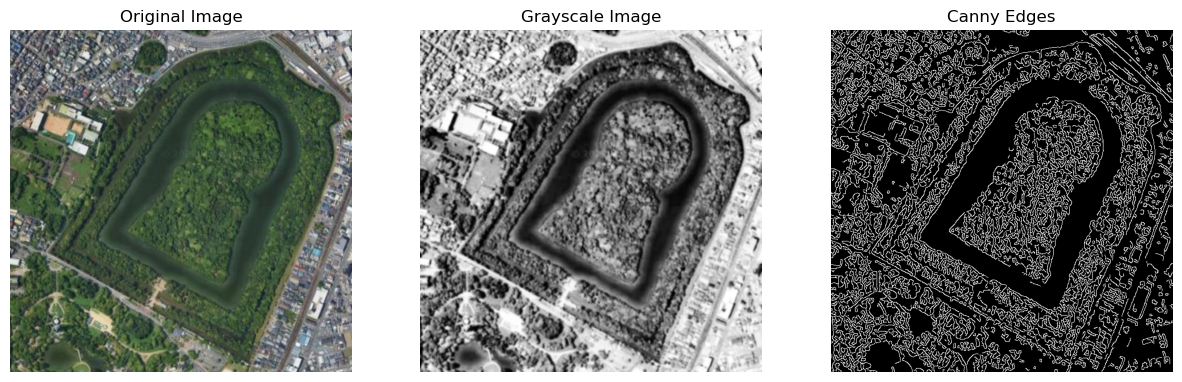

In [246]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

use_image= img[0:600,700:1300]
#Stadard values 
min_val = 100
max_val = 200
# Apply Canny Edge Detection
edges = cv2.Canny(gray, min_val, max_val)
#edges = cv2.Canny(use_image, min_val, max_val,apertureSize=5,L2gradient = True )
#False
# Show the result
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(cv2.cvtColor(use_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.axis('off')
plt.subplot(132), plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image'), plt.axis('off')
plt.subplot(133), plt.imshow(edges, cmap='gray')
plt.title('Canny Edges'), plt.axis('off')
plt.show()

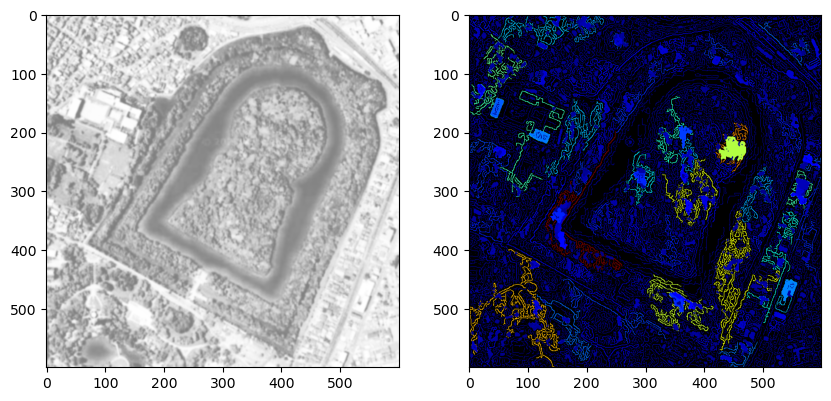

In [245]:
# Edges to contours 
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Calculate contour areas
areas = [cv2.contourArea(contour) for contour in contours]

# Normalize areas for the colormap
normalized_areas = np.array(areas)
if normalized_areas.max() > 0:
    normalized_areas = normalized_areas / normalized_areas.max()

# Create a colormap
cmap = plt.cm.jet

# Plot the contours with the color map
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray', alpha=0.5)  # Display the grayscale image in the background
mask = np.zeros_like(use_image)
for contour, norm_area in zip(contours, normalized_areas):
    color = cmap(norm_area)  # Map the normalized area to a color
    color = [int(c*255) for c in color[:3]]
    cv2.drawContours(mask, [contour], -1, color,-1 )  # Draw contours on the image
    
plt.subplot(1,2,2)
plt.imshow(mask)

# Kmean Color segmentation 

Text(0.5, 1.0, 'Kmean Segmented Image K=4')

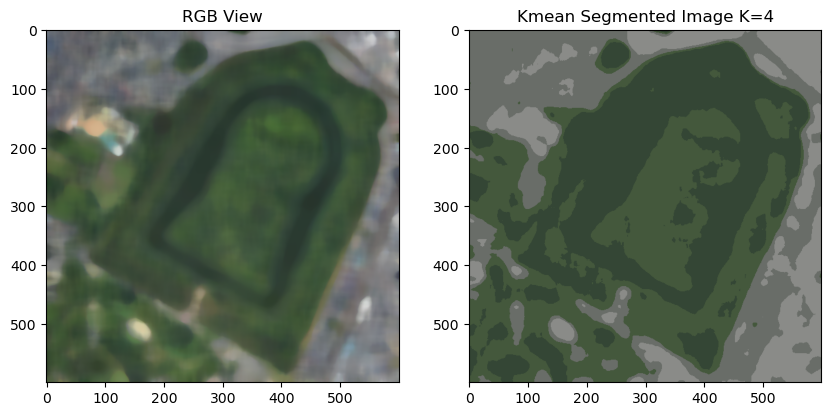

In [293]:
# Kmean color segmentation
use_image= img[0:600,700:1300]
use_image = cv2.medianBlur(use_image, 25)


 # Reshape image for k-means
pixel_values = use_image.reshape((-1, 3)) if len(use_image.shape) == 3 else use_image.reshape((-1, 1))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
attempts=10
ret,label,center=cv2.kmeans(pixel_values,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

centers = np.uint8(center)
segmented_data = centers[label.flatten()]
segmented_image = segmented_data.reshape(use_image.shape)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1),plt.imshow(use_image[:,:,::-1])
plt.title("RGB View")
plt.subplot(1,2,2),plt.imshow(segmented_image[:,:,[2,1,0]])
plt.title(f"Kmean Segmented Image K={K}")

(-0.15000000000000002, 3.15, -0.05, 1.05)

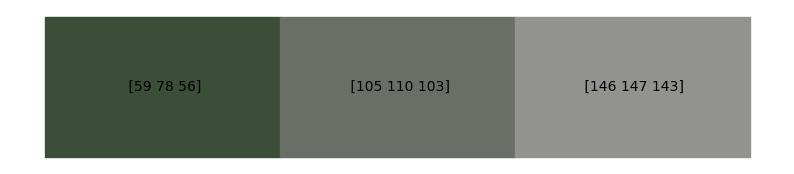

In [167]:
# View colors of segmented image 
colors=np.unique(segmented_image[:,:,::-1].reshape(-1,3),axis=0)
plt.figure(figsize=(10, 2))
for i, color in enumerate(colors):
    plt.fill_between([i, i+1], 0, 1, color=color/255.0)  # Normalize RGB to [0,1] range
    plt.text(i+0.5, 0.45, f" {color}", ha='center', va='bottom')
plt.axis('off')


2
3
5
7
9
12
15


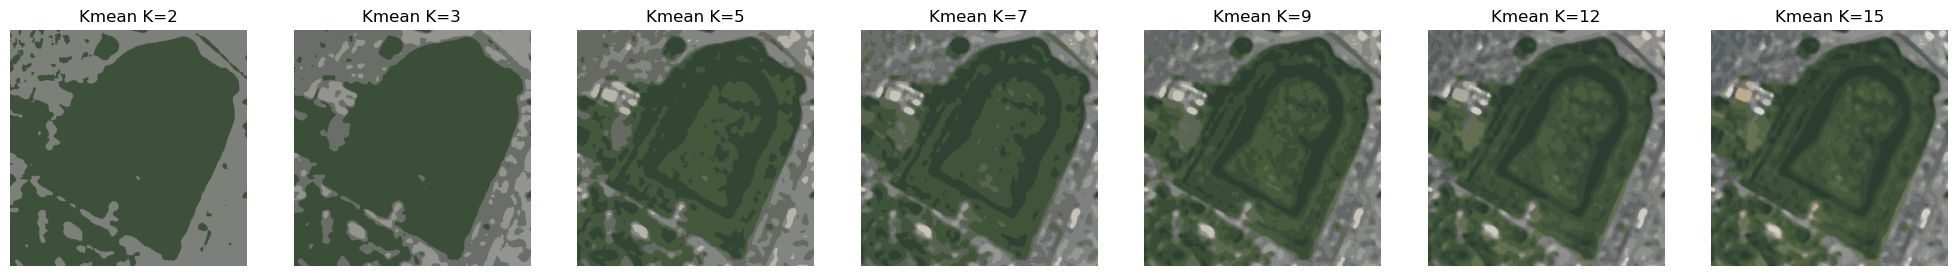

In [193]:
ks = [2,3,5,7,9,12,15]
results = []
plt.figure(figsize=(25, 6))

pixel_values = use_image.reshape((-1, 3)) if len(use_image.shape) == 3 else use_image.reshape((-1, 1))
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

attempts=10

for i,k in enumerate(ks):
    print(k)
    ret,label,center=cv2.kmeans(pixel_values.copy(),k,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    segmented_data = center[label.flatten()]
    segmented_image = segmented_data.reshape(use_image.shape)
    results.append(segmented_image)
    segmented_image=np.array(segmented_image,dtype=np.uint8)
    plt.subplot(1,len(ks),i+1)
    plt.imshow(segmented_image[:,:,[2,1,0]])
    plt.title(f"Kmean K={k}")
    plt.axis('off')

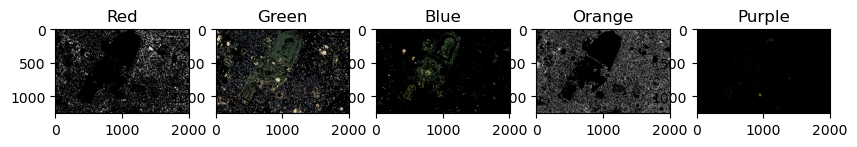

In [194]:
#in Range Threaholding 
Red =    (255, 0, 0)
Green =  (0, 255, 0)
Blue =   (0, 0, 255)
Orange = (255, 165, 0)
Purple = (128, 0, 128)

# Define H-channel ranges for each color
# Note: OpenCV uses H ranges [0, 180] instead of [0, 360] for Hue.
color_ranges = {
    "Red": [0, 10],  # Red can also wrap around to [160, 180] for another range
    "Green": [35, 85],
    "Blue": [90, 130],
    "Orange": [10, 25],
    "Purple": [130, 160]
}
hsv_img =cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


# Initialize a blank image for final segmentation
#segmented_image = np.zeros_like(img)
segmented_images=[]
# Loop through each color range and segment
for color, (lower_h, upper_h) in color_ranges.items():
    # Create masks for the H-channel only
    mask = cv2.inRange(hsv_img[:, :, 1], lower_h, upper_h)
    
    # Apply the mask to the original image
    segmented_color = cv2.bitwise_and(img, img, mask=mask)
    #segmented_image = cv2.add(segmented_image, segmented_color)
    segmented_images.append(segmented_color)


fig = plt.figure(figsize=(10, 6))
for i, segmented_color in enumerate(segmented_images):
    ax = fig.add_subplot(1, len(segmented_images), i + 1)
    ax.imshow(segmented_color[:,:,[2,1,0]])
    ax.set_title(f"{list(color_ranges.keys())[i]}")

In [ ]:
## Wathering segmentation method


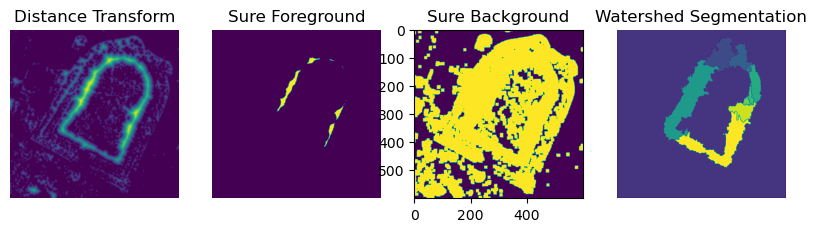

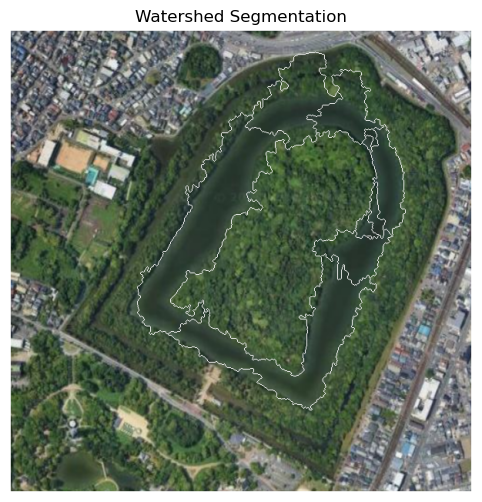

In [289]:
# Wathering segmentation method
img=cv2.imread(files[0])
use_image= img[0:600,700:1300].copy()
# Convert to grayscale and apply threshold

gray = cv2.cvtColor(use_image, cv2.COLOR_BGR2GRAY)
#gray = cv2.GaussianBlur(gray, (9, 9),3)
#gray = cv2.medianBlur(gray, 9)
gray = cv2.equalizeHist(gray)
#_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY_INV  | cv2.THRESH_OTSU)


# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Distance transform and sure foreground
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

# Watershed markers
markers = cv2.connectedComponents(sure_fg.astype(np.uint8))[1]
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed
markers = cv2.watershed(use_image, markers)
use_image[markers == -1] = [255, 255, 255]  # Mark boundaries in red
#Show Seg progress 

plt.figure(figsize=(10, 6))
plt.subplot(141),plt.imshow(dist_transform)
plt.title('Distance Transform')
plt.axis('off')
plt.subplot(142),plt.imshow(sure_fg)
plt.title('Sure Foreground')
plt.axis('off')
plt.subplot(143),plt.imshow(sure_bg)
plt.title('Sure Background')
plt.subplot(144),plt.imshow(markers)
plt.title('Watershed Segmentation')
plt.axis('off')
plt.show()


# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(use_image, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation')
plt.axis('off')
plt.show()

In [263]:
np.dtype(sure_fg)

TypeError: Cannot construct a dtype from an array

In [257]:
sure_bg,sure_fg

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0]], dtype=uint8),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))